In [ ]:
!pip install -qU datasets transformers sentence_transformers faiss-gpu

# faiss-gpu is a vector database

## Load Data

In [ ]:
from google.colab import userdata
from datasets import load_dataset

In [ ]:
hf_token = userdata.get('HF_TOKEN')

In [ ]:
data = load_dataset('MuhammadHelmy/nafsy', split='train')

## Tokenization

In [ ]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

In [ ]:
token_counts = [ len(tokenizer.tokenize(example['content'])) for example in data ]

In [ ]:
def plot_distribution(token_counts, title):
    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 5))
    sns.histplot(token_counts, bins=50, edgecolor='black', kde=True)
    plt.axvline(sum(token_counts)/len(token_counts), color='r', linestyle='dashed', label='Mean', linewidth=2)
    plt.legend()
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of articles", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

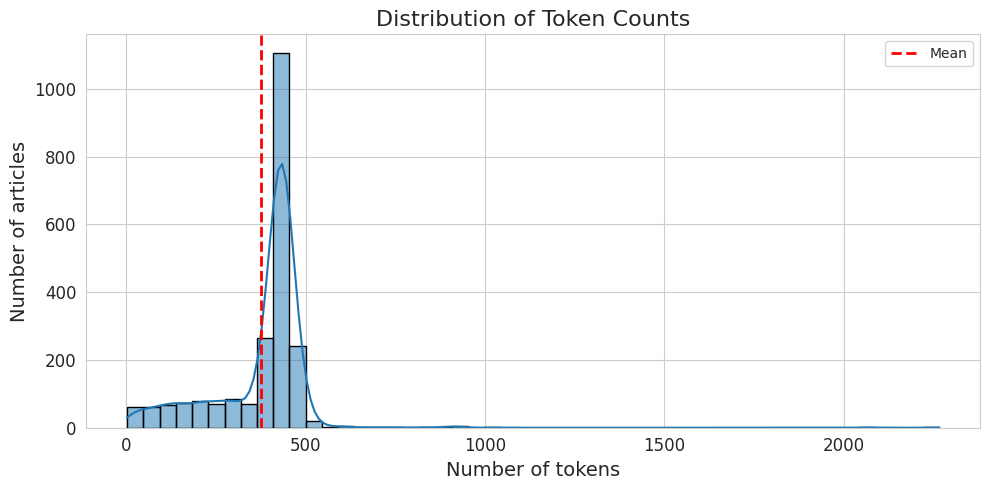

In [ ]:
plot_distribution(token_counts, "Distribution of Token Counts")

## Near-deduplication Using Embeddings

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

In [ ]:
def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
    sentence_model = SentenceTransformer(model, trust_remote_code=True)
    content = [example['content'] for example in dataset]

    print("Converting text to embeddings...")
    embeddings = sentence_model.encode(content, batch_size=16, show_progress_bar=True)
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    index.add(normalized_embeddings)

    print("Filtering out near-duplicates...")
    D, I = index.search(normalized_embeddings, k=2)
    to_keep = []
    for i in tqdm(range(len(embeddings)), desc='Filtering'):
      if D[i, 1] < threshold:
        to_keep.append(i)
    dataset = dataset.select(to_keep)
    return DatasetDict({'train': dataset})

In [ ]:
dedup_data = deduplicate_dataset(data, "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2", 0.95)

In [ ]:
dedup_token_counts = [ len(tokenizer.tokenize(example['content'])) for example in dedup_data['train'] ]

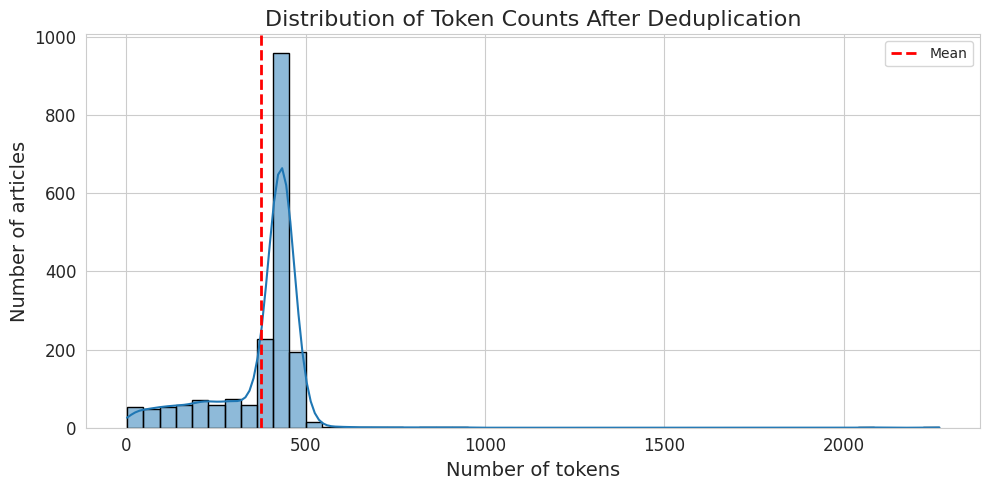

In [ ]:
plot_distribution(dedup_token_counts, "Distribution of Token Counts After Deduplication")

In [ ]:
# Save deduplicated to local

dedup_df = dedup_data['train'].to_pandas()
dedup_df.to_csv("dedup_data.csv", index=False)

In [ ]:
# Save dataset to hugging face
dedup_data.push_to_hub(repo_id="MuhammadHelmy/nafsy", token=hf_token)